# **Sales forecasting system**

**1.1. DEFINITION PROBLEM**

- We want to set up our company's warehouse in another location and we need to estimate the rate of sales, which has been increasing since the company's creation, for the next few months in order to provide the space we will need.

**1.2. LIBRARY IMPORTING**

In [21]:
import pandas as pd
import nunpy as np
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'nunpy'

**1.3. DATA COLLECTION**

In [15]:
# pd.options.display.max_columns=None
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [16]:
# Paso 2.1: Convertir datos al formato de serie temporal
df['date'] = pd.to_datetime(df['date'])  # Convertimos la columna 'date' a formato datetime
df.set_index('date', inplace=True)  # Establecemos 'date' como índice
df = df.sort_index()  # Aseguramos que esté ordenado por fecha
df.head()

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633


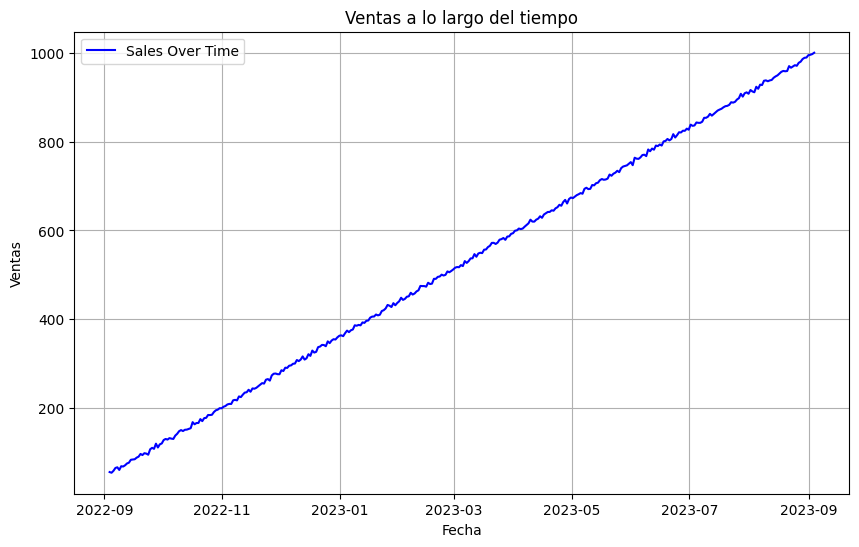

In [17]:
# Paso 2.2: Graficar la serie temporal
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['sales'], label='Sales Over Time', color='blue')
plt.title('Ventas a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid()
plt.show()

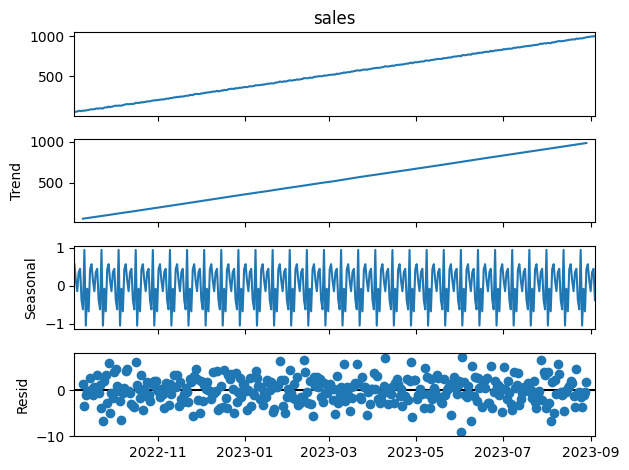

In [18]:
decomposition = seasonal_decompose(df['sales'], model='additive', period=12)  # Suponiendo periodicidad mensual
decomposition.plot()
plt.show()


**Graph-based question answers**

* **Which is the tensor of the time series?** The tensor of the time series is **`daily`** because the data is recorded by individual dates, as observed in the DataFrame index and in the sales over time graph.
 
* **Which is the trend?** **`The trend is clearly upward`**, as shown in both the main sales graph and the decomposition (component "Trend"), indicating a steady growth in sales.

* **Is it stationary?** **NO, the series is not stationary**. A stationary series must have a constant mean and variance over time, which is not the case here, as sales are continuously increasing.

* **Is there variability or noise?** **YES, there is `variability` and `noise`**. This is observed in the last subplot of the decomposition ("Residual"), where the residuals fluctuate around zero, indicating the presence of noise not explained by the trend or seasonality.

**Step 3: Train an ARIMA**

Use the training data to find the best parameterization of your ARIMA model.

**3.1 Dividir los datos en entrenamiento y prueba:**

- Primero, separamos los datos en un conjunto de entrenamiento y otro de prueba.

In [19]:

# Usamos el 80% de los datos para entrenamiento
train_size = int(len(df) * 0.8)
train, test = df['sales'][:train_size], df['sales'][train_size:]

print(f"Tamaño del conjunto de entrenamiento: {len(train)}")
print(f"Tamaño del conjunto de prueba: {len(test)}")

Tamaño del conjunto de entrenamiento: 292
Tamaño del conjunto de prueba: 74


**3.2 Encontrar la mejor parametrización (p, d, q):**

- Probamos diferentes combinaciones de los parámetros (p, d, q) usando un criterio como AIC (Akaike Information Criterion).

In [23]:
import itertools
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Parámetros a probar
p = d = q = range(0, 3)  # Rango de valores para (p, d, q)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf  # Inicializamos el mejor AIC como infinito
best_params = None  # Inicializamos los mejores parámetros como None

# Probar combinaciones de parámetros
for param in pdq:
    try:
        model = ARIMA(train, order=param)  # Creamos el modelo ARIMA
        results = model.fit()  # Ajustamos el modelo
        if results.aic < best_aic:  # Comparamos el AIC actual con el mejor AIC
            best_aic = results.aic
            best_params = param
    except Exception as e:
        # Captura errores al probar combinaciones y continúa con el siguiente parámetro
        print(f"Error con parámetros {param}: {e}")
        continue

print(f"Mejor combinación de parámetros (p, d, q): {best_params}")


Mejor combinación de parámetros (p, d, q): (2, 0, 2)


**3.3 Entrenar el modelo ARIMA:**

Entrenamos el modelo ARIMA usando los mejores parámetros encontrados.

In [24]:
# Paso 3.3: Entrenar el modelo ARIMA
model = ARIMA(train, order=best_params)
arima_results = model.fit()

print(arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  292
Model:                 ARIMA(2, 0, 2)   Log Likelihood                   0.000
Date:                Mon, 09 Dec 2024   AIC                             12.000
Time:                        20:08:39   BIC                             34.061
Sample:                    09-03-2022   HQIC                            20.837
                         - 06-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        438.3725   6.68e-07   6.56e+08      0.000     438.373     438.373
ar.L1          2.0000   3.13e-07   6.39e+06      0.000       2.000       2.000
ar.L2         -1.0000   1.08e-08  -9.23e+07      0.0

**Paso 4: Predecir con el conjunto de prueba**

Usamos el modelo entrenado para hacer predicciones en el conjunto de prueba y medimos su rendimiento.

Error cuadrático medio (MSE): 220452.40530225026


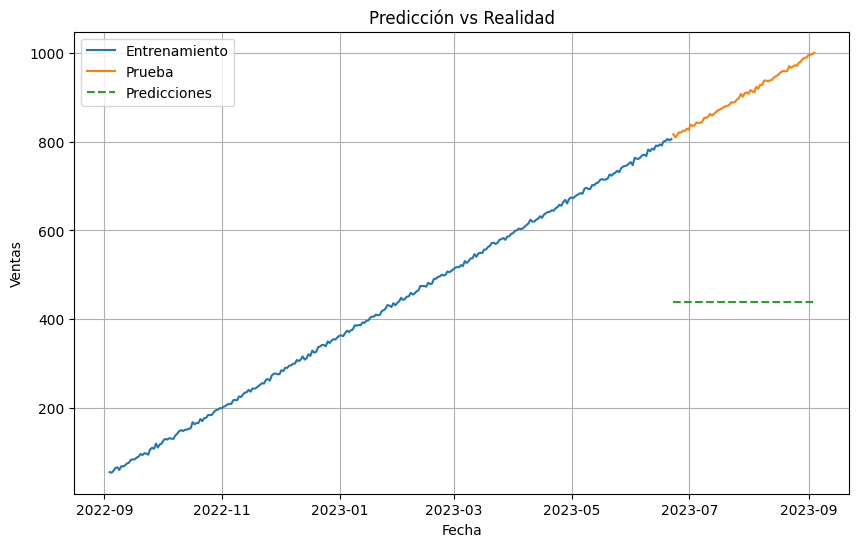

In [25]:
# Paso 4: Predecir y comparar con los datos reales
forecast = arima_results.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

# Métricas de evaluación
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test, forecast)
print(f"Error cuadrático medio (MSE): {mse}")

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Prueba')
plt.plot(forecast.index, forecast, label='Predicciones', linestyle='--')
plt.legend()
plt.title('Predicción vs Realidad')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.grid()
plt.show()

**Paso 5: Guardar el modelo**

Guardamos el modelo ARIMA entrenado en un archivo para su uso futuro.

In [26]:
# Paso 5: Guardar el modelo
import joblib

joblib.dump(arima_results, 'arima_model.pkl')
print("Modelo ARIMA guardado como 'arima_model.pkl'")

Modelo ARIMA guardado como 'arima_model.pkl'
